# DA023 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA023'
subj_format = ['edf']
subj_site = ['UCD']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 125 x 983040 (1920.0 s), ~937.7 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 983040 (1920.0 s), ~7.6 MB, data loaded>

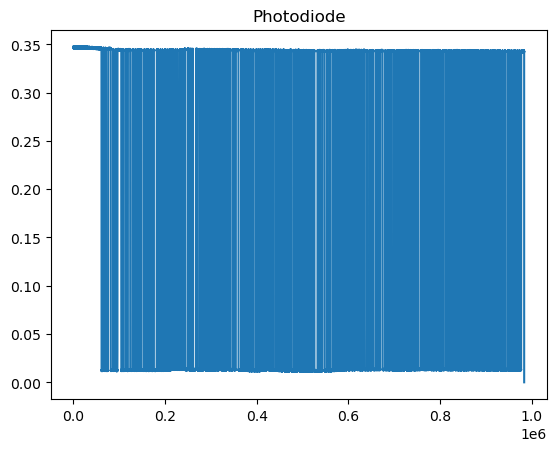

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAC1,A32p_L,-2.948270,35.165349,28.967987,-3.244003,29.783249,18.898609,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus G,NaN
1,LAC10,A8dl_L,-17.340510,32.767711,56.937081,-18.622061,32.069451,49.930015,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 4 D
2,LAC11,A8dl_L,-19.339433,32.368105,60.133549,-20.763493,32.332690,53.556836,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 4 D,NaN
3,LAC12,A8dl_L,-20.938571,31.968499,62.930459,-22.441373,32.456241,56.694248,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 4 D,OOB
4,LAC13,Unknown,-22.537708,31.968499,65.727368,-24.123625,33.000428,59.764154,Unknown,Unknown,Unknown,Unknown,Unknown,Left superior frontal gyrus 4 D,OOB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,LSMG5,A40c_L,-53.720895,-36.763783,29.367546,-54.075538,-48.517991,33.446039,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
146,LSMG6,A40c_L,-57.318955,-36.364177,30.166663,-57.724920,-47.936912,34.325547,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
147,LSMG7,A40c_L,-60.517231,-36.364177,30.965780,-60.975772,-47.795985,35.269393,Gray,Left SMG supramarginal gyrus,Area PFm (IPL),L SupraMarginal Gyrus,L IPL,Left supramarginal gyrus 3 B,NaN
148,LSMG8,A40c_L,-63.715506,-35.964570,31.764897,-64.342587,-47.285110,36.142847,Unknown,Left SMG supramarginal gyrus,Area PFm (IPL),Unknown,L IPL,Left supramarginal gyrus 3 B,OOB


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,68.0,gain,226.667426,226.671416,228.779282,230.796562,2.107865,0.3,0.00,...,0.000000,0.621712,0.378288,0.000000,0.000000,0.237822,0.000000,0.000000,0.539776,0.237822
1,2,85.0,gain,234.872443,234.893133,239.441643,241.458694,4.548509,0.5,0.00,...,0.000000,0.561012,0.438988,0.000000,0.000000,0.117409,0.000000,0.000000,0.619281,0.117409
2,3,76.0,gain,246.187263,246.203895,249.303626,251.320210,3.099731,0.4,0.00,...,0.000000,0.581612,0.418388,-0.559658,-0.559658,-0.401981,-0.559658,-0.401981,0.000000,0.000000
3,4,56.0,gain,264.647861,264.666498,269.161376,271.178256,4.494878,0.2,0.00,...,0.000000,0.541234,0.458766,-0.280877,-0.280877,-0.201743,-0.280877,-0.201743,0.000000,0.000000
4,5,31.0,mix,276.618198,276.635340,280.822825,280.831447,4.187485,0.0,-1.50,...,-1.395232,0.109206,0.890794,0.000000,1.395232,1.395232,0.000000,0.000000,1.395232,1.395232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,74.0,gain,1887.903226,1887.904228,1889.144100,1891.160797,1.239872,0.4,0.00,...,0.000000,0.522598,0.477402,0.000000,0.000000,0.043298,0.000000,0.000000,0.445280,0.043298
146,147,88.0,gain,1895.726328,1895.727413,1896.891048,1898.907664,1.163636,0.5,0.00,...,0.000000,0.695457,0.304543,0.000000,0.000000,0.395280,0.000000,0.000000,0.897152,0.395280
147,148,144.0,loss,1905.271849,1905.272834,1907.119859,1907.126331,1.847025,-0.6,-1.33,...,-1.237908,0.439613,0.560387,0.000000,0.116194,0.116194,0.000000,0.000000,0.116194,0.116194
148,149,87.0,gain,1914.370711,1914.383463,1915.948606,1917.965770,1.565143,0.5,0.00,...,0.000000,0.645163,0.354837,-0.788054,-0.788054,-0.501872,-0.788054,-0.501872,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [12]:
test_photo = photodiode_data

In [13]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [14]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            test_photo, 
                                            smoothSize=5, windSize=5, height=0.5)

31 blocks
...............................

found matches for 150 of 157 pulses
15 blocks
...............

found matches for 140 of 157 pulses
10 blocks
..........

found matches for 120 of 157 pulses


In [15]:
print(slope,offset)

0.9999972480972702 -22.27880901620597


In [14]:
print(slope,offset)

1.2609658188729458 -991.9348626774815


## Make epochs

In [16]:
list(behav_df['DecisionOnset'])

[228.7792818823309,
 239.44164274204013,
 249.3036262918185,
 269.16137628354136,
 280.8228251004284,
 290.3850530790487,
 305.47837396964223,
 319.1050071219215,
 328.3174489288449,
 345.46014983853183,
 356.9879072406029,
 371.91490729214456,
 386.90817039499416,
 395.38764379949134,
 405.5825403874205,
 418.7765321005281,
 427.3898317465309,
 436.40233103399805,
 451.26189930869714,
 459.6085172238536,
 470.9533564507065,
 482.5643258136452,
 491.0610952637599,
 503.48819071798425,
 516.6493860948285,
 525.1121488404733,
 538.922238109395,
 554.9982093650278,
 564.3772590723856,
 572.6573459895208,
 586.9508377516095,
 596.2133459990773,
 606.2583374947562,
 617.1205937699151,
 627.63240407593,
 637.4277781210076,
 652.8372259562202,
 662.2162712262434,
 669.8965882703515,
 684.506604630461,
 698.0005420374255,
 708.8452479735888,
 731.5015696216014,
 740.1147777902552,
 750.893432301812,
 762.3548242525567,
 771.0004174507376,
 781.7459407779743,
 795.1899103897449,
 803.1029744815

In [17]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [18]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [19]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [20]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 17618 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 18750 out of 18750 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 18058 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 18750 out of 18750 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [21]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~220.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~366.5 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [22]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [23]:
epochs_all_evs[event].metadata

,lam8,lam14,lam15,lam16,lah7,lah14,lah15,lpmtg1,lpmtg8,lpmtg9,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.540,0.540,0.00,0.78,0.00,0.0,1.08,0.78,0.539776,0.301954
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.620,0.620,0.00,0.74,0.00,0.0,1.24,0.74,0.619281,0.501872
2,NaN,NaN,NaN,NaN,NaN,[2088],[2088],NaN,NaN,NaN,...,0.560,-0.560,-1.12,-0.40,-1.12,-0.4,0.00,0.00,0.559658,0.401981
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280,-0.280,-0.56,-0.20,-0.56,-0.2,0.00,0.00,0.280877,0.201743
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.78,-0.78,0.00,0.0,1.50,1.50,-1.004709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.445,0.445,0.00,0.49,0.00,0.0,0.89,0.49,0.445280,0.401981
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.900,0.900,0.00,1.30,0.00,0.0,1.80,1.30,0.897152,0.501872
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.0,0.73,0.73,-1.237908,-1.121714
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.790,-0.790,-1.58,-0.50,-1.58,-0.5,0.00,0.00,0.788054,0.501872


### Save epoched data

In [24]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)